<center><h1>Neuroscience Final Project</h1></center>
<center><h2>Deep Q Networks</h2></center>

In this notebook, we are going to get familiar with Deep Q Networks. You have been introduced to Reinforcement Learning in the course. Deep Q Networks are an entension of Reinforcement Learning were we incorporate Deep Neural Networks in our policy enhacement procedure.

We also implement an Agent in an online learning environment, meaning that the agent has no initial memory of the rewards in each state. We go through the environment based on our policy and store the observed rewards and corresponding state in the memory of the agent

Finally, we utilize the Agent in a practical Maze Solving problem. The agent is prompted to iterate the maze from a defined starting point to an ending point, maximing the profit from the total route.

**Name** : AmirHossein Zahedi

**Student ID**: 99101705

## Importing the necessary packages

In [28]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Creating the Deep Q Network

In [29]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*input_dims, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        # Calculate the forward pass. Use Proper non-linear activation function between the linear layers
        outputs_layer1 = F.relu(self.fc1(state))
        outputs_layer2 = F.relu(self.fc2(outputs_layer1))
        actions = self.fc3(outputs_layer2)

        return actions

<div dir="rtl">
در این بخش می خواهیم تابع یک مدل یادگیری عمیق سه لایه با کانکشن های کامل درست
 کنیم که به عنوان ورودی تابع به آن ابعاد ورودی ها، خروجی های لایه اول و دوم و خروجی نهایی را به همراه لرنینگ ریت، می دهیم. <br>
 نورون ها را به صورت خطی تعریف می کنیم یعنی که با ورودی هایش ابتدا ترکیبی خطی تولید می کند که با خروجی این ترکیب خطی، و اکتیویشن فانکشنی که در بخش بعدی تعیین شده است، (ReLu) ، خروجی نهایی هر نرون مشخص می گردد. <br>
  این مدل از اپتیمایزر adam برای آپدیت پارامتر ها با استفاده از خطای MSE استفاده می کند. <br>
  برای تکمیل تابع اول لازم بود که دیمانسیون های ورودی و خروجی هر لایه به درستی مشخص شود و در تابع دوم نیز باید روند خروجی گرفتن با دادن ورودی به صورت فوروارد مشخص شود که صرفا لازم بود ترتیب ورودی ها و خروجی ها و اکتیویشن فانکشن مشخص شود.
</div>

## Creating the Agent

In [30]:
class Agent:
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
                 max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0

        # Create an instance of the Deep Q network with 256 neurons in each of its hidden layers
        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool_)


    # Store one episode alongside its reward, state, next_state
    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1


    # Choose the best action with probability (1 - epsilon), otherwise choose a random direction from the action space
    # The best action is defined as the maximum output of the Deep Q Network
    def choose_action(self, observation):
        # Considering randomness of decision making
        prob_defined_decision = np.random.random()
        prob_random_decision = self.epsilon
        if prob_defined_decision > prob_random_decision:
            # Getting current state
            state = T.tensor([observation]).to(self.Q_eval.device)
            # Getting probs of all actions
            possible_actions = self.Q_eval.forward(state)
            # Choosing the best action
            action = T.argmax(possible_actions).item()
        else:
          # Finding a raandom action between actions
            action = np.random.choice(self.action_space)

        return action

    # Train the Deep Q Network based on the new observations
    # The network must learn the target Q values through regression
    def learn(self):
        # Simply ignore the training phase if there is not enough memory stored yet
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        # Choose a random batch of data from the memory
        # Finding maximum capacity of memories for batch
        mem_max = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(mem_max, self.batch_size, replace=False)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        # Current state Q-value as predicted by the network
        # Note to filter the matrix to only q-values corresponding to our "action_batch"
        q_eval = self.Q_eval.forward(state_batch)[np.arange(self.batch_size), action_batch]

        # Next state Q-value as predicted by the network for all possible next actions
        q_next = self.Q_eval.forward(new_state_batch)
        q_next = T.max(q_next, dim=1)[0]
        q_next[terminal_batch] = 0.0

        # The target Q-value of our current state with a discount factor of gamma
        q_target = reward_batch + (self.gamma * q_next)

        # Make the network learn this target Q-value via a proper definitio of loss function
        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1

        # Reduce the epsilon by its decay factor it possible
        if self.epsilon > self.eps_min:
            self.epsilon -= self.eps_dec
        else:
            self.epsilon = self.eps_min

<div dir="rtl">
همانطور که مشخص شده بود، توابعی نیاز به تکمیل شدن داشتند. در تابع store_transition تغییر استیت فعلی به استیت بعدی انجام می شود به این صورت که استیت فعلی، استیت بعدی، عمل انجام شده، پاداش و تمام شدن یا نشدن اکشن، ثبت می شوند. <br>
در تابع choose_action انتخاب می کنیم که کدام عمل را انتخاب کنیم. برای تصمیم گیری احتمال رندومی را در نظر می گیریم که اگر از اپسیلون بزرگتر باشد، استیت فعلی را به مدل میدهیم و تصمیم میگیریم که کدام عمل احتمال بیشتری را دارد و آن را اتخاذ می کنیم اما اگر احتمال کمتر از اپسیلون باشد، صرفا تصمیمی به صورت تصادفی گرفته می شود. <br>
تابع learn همانطور که از اسمش نیز مشخص است، تابعی است تا با آن شبکه عصبی را در الگوریتم یادگیری تقویتی آموزش دهیم. ابتدا تعدا تجارب بررسی می شود که آیا کافی هستند یا خیر. سپس بک بچ از تجربیات قبلی انتخاب می شوند. با توجه به استیت ها و پاداش های تجارب انتخاب شده، مدل مقادیر Q که پاداش فوری و پاداش مورد انتظار را شامل هستند محاسبه می کند. پس از آن با استفاده از خطای این مقادیر با قبل، مدل مجدد تیون می شود و پارامتر هایش آپدیت می شود که این فرایند با الگوریتم بک پروپگیشن انجام می شود. اینگونه مدل آموزش می یابد. اپسیلون نیز که میزان تصادفی بودن تصمیم را تعیین می کرد با افزایش یادگیری کاهش می یابد. البته کاهش اپسیلون، تصمیم گیری را بیشتر بر اساس تجربه می کند تا جست و جو کردن بین راه های مختلف.
</div>

## Working with the Maze environment

In [41]:
from maze import MazeEnvironment
import warnings
warnings.filterwarnings('ignore')

# Create a maze environment
# You can create a new one or use the files stored in directory mazes to load a maze
env = MazeEnvironment(dim=50, maze_path='maze1.npy')

agent = Agent(gamma=0.99, epsilon=1.0, batch_size=2, n_actions=4, eps_end=0.05, input_dims=[2], lr=0.0001)
scores = []
avg_scores = []
n_games = 50

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    counter = 0
    while not done:
        counter += 1
        # If performed 1000 moves and didn't finish the maze, reset the environment
        if (counter == 1000):
            counter = 0
            score = 0
            observation = env.reset()

        # Make the agent choose an action
        action = agent.choose_action(observation)

        # Retrieve the reward and next_state from the envirinment
        observation_, reward, done = env.step(action)

        score += reward

        # Store the current episode in the memory
        agent.store_transition(observation,action,reward,observation_,done)

        # Learn the current episode
        agent.learn()

        # Change the next state to the current state
        observation = observation_

    scores.append(score)

    avg_score = np.mean(scores[-100:])
    avg_scores.append(avg_score)

    print('episode ', i, 'score %.2f' % score, 'average score %.2f' % avg_score, 'epsilon %.2f' % agent.epsilon)

episode  0 score 514.00 average score 514.00 epsilon 0.66
episode  1 score 2144.00 average score 1329.00 epsilon 0.47
episode  2 score 3208.00 average score 1955.33 epsilon 0.05
episode  3 score 3958.00 average score 2456.00 epsilon 0.05
episode  4 score 473.00 average score 2059.40 epsilon 0.05
episode  5 score 1101.00 average score 1899.67 epsilon 0.05
episode  6 score 1303.00 average score 1814.43 epsilon 0.05
episode  7 score 4882.00 average score 2197.88 epsilon 0.05
episode  8 score 2330.00 average score 2212.56 epsilon 0.05
episode  9 score 4971.00 average score 2488.40 epsilon 0.05
episode  10 score 1856.00 average score 2430.91 epsilon 0.05
episode  11 score 5252.00 average score 2666.00 epsilon 0.05
episode  12 score 3661.00 average score 2742.54 epsilon 0.05
episode  13 score 4902.00 average score 2896.79 epsilon 0.05
episode  14 score 4368.00 average score 2994.87 epsilon 0.05
episode  15 score 6384.00 average score 3206.69 epsilon 0.05
episode  16 score 6497.00 average sco

<div dir="rtl">
در ادامه کلاسی که برای یک عامل یادگیرنده تعریف کردیم که این کلاس حاوی توابع یادگیری، ذخیره سازی در حافظه و تصمیم گیری بود، در این بخش کد یادگیری تقویتی را برای یک ماز اجرا می کنیم. <br>
محیط ماز را با مشخص کردن گاما، اپسیلون، سایز بچ، تعداد انتخاب ها، مینیمم اپسیلون، ابعاد ورودی و ریت یادگیری میسازیم. سپس تا زمانی که ماز حل نشده باشد، یادگیری را ادامه می دهیم به این صورت که عامل در هر مرحله اقدام بعدی خود را انتخاب می کند، پاداشش و استیت بعدی را دریافت می کند. همچنین به واسطه استیت ها و پاداش دریافت کرده، فرایند یادگیری انجام شده و استیت فعلی تغییر می کند. اینگونه با هر عمل، تجربیات و یادگیری هایش به روز می شود و احتمالا بهتر می گردد. در نهایت امتیاز ها چاپ می شوند. <br>
در ابتدا تعداد بازی ها 50 تا در نظر گرفته شده و اگر عامل بیش از 1000 در هر بازی حرکت انجام میداد، فرایند ریست می شد تا یادگیری از ابتدا آغاز شود زیرا که عملکرد مناسبی نداشته است.
</div>

## Report

Try to manipulate constants such as batch_size, epsilon, gamma, .... Try to achieve the maximum score.

Grading will not be based on the best scores. However, higher scores can bring bonus grade!

Plot the incrementation of your score through n games and try to justify the patterns.

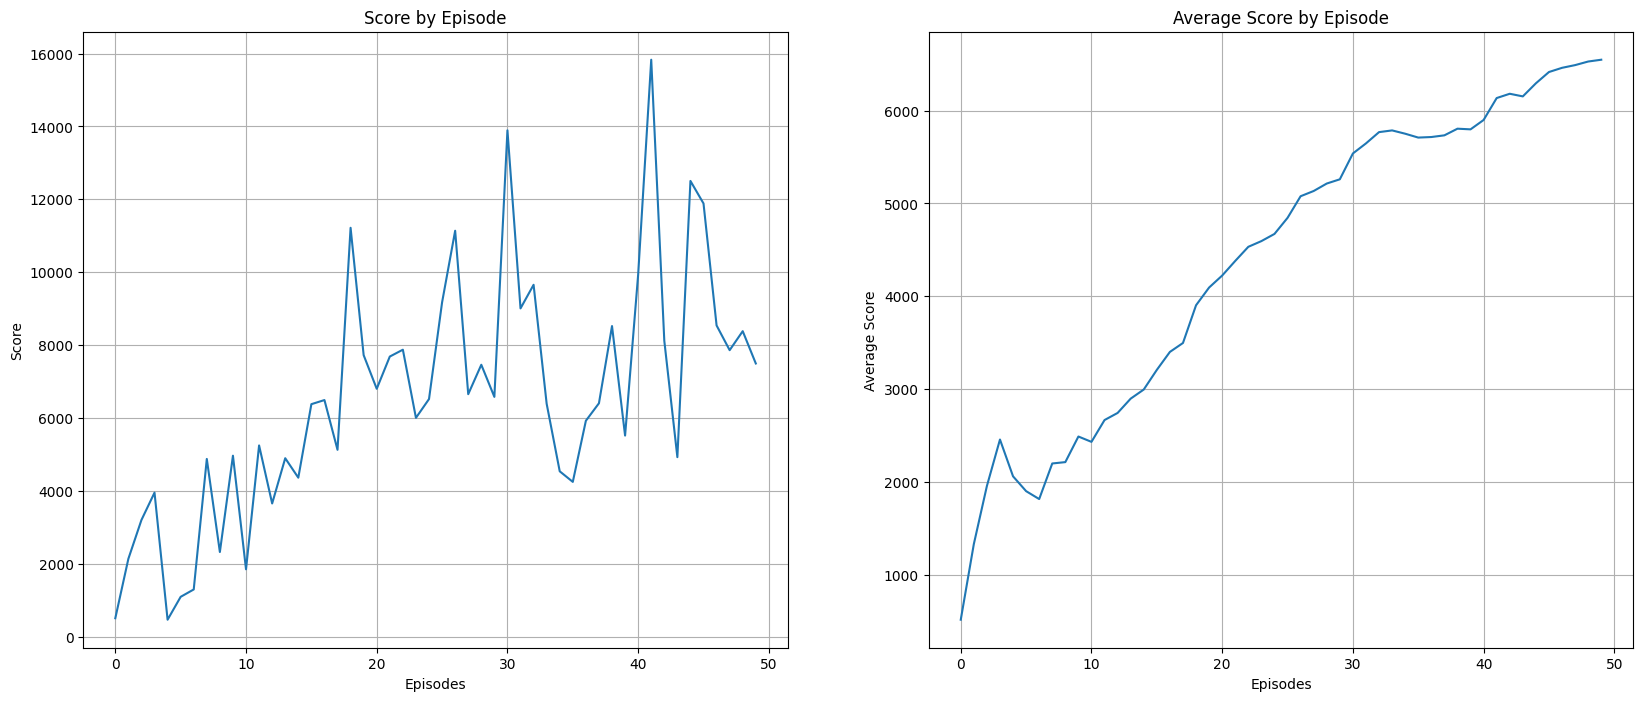

In [47]:
# Plotting score per episode (game)
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.plot(scores)
plt.title('Score by Episode')
plt.xlabel('Episodes')
plt.grid()
plt.ylabel('Score')

# Plotting average score per episode (game)
import matplotlib.pyplot as plt
plt.subplot(1,2,2)
plt.plot(avg_scores)
plt.title('Average Score by Episode')
plt.xlabel('Episodes')
plt.ylabel('Average Score')
plt.grid()
plt.show()

<div dir="rtl">
همانطور که انتظار داشتیم اسکور هر بازی روندی صعودی دارد که دال بر انجام شدن یادگیری تقویتی است. البته صعودی یکنوا نیست و نویز هایی دارد که با بخش اختیاری پایین می تواند رفع شود. <br>
وضعیت میانگین امتیازات به دلیل تاثیر نویز کمتر بر روی آن همانطور که دیده می شود بهتر است و خیلی زیبا صعودی است.
</div>

## (Bonus) Target Q Network

Instead of calculating the target q-value using the formula presented, you can use anonther Deep Neural Network to predict the target Q-values via regression!

Implementing the target Q network alonside the eval Q network can lead to more steady behavior of the final score.